In [1]:
from google.colab import drive
drive.mount('/content/drive')

#Optional: move to the desired location:
%cd drive/My Drive/Colab/Shaki_Vai

Mounted at /content/drive
/content/drive/My Drive/Colab/Shaki_Vai


In [2]:
!pip install HydroErr
!pip install SeqMetrics

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU, Activation
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import HydroErr as he
from SeqMetrics import RegressionMetrics
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from keras.models import load_model

  Preparing metadata (setup.py) ... done
  Created wheel for HydroErr: filename=HydroErr-1.24-py3-none-any.whl size=20183 sha256=690d2e91d058073208e3f94627d8b58b42b41d4a43f27c4f7077551fc643418e
  Stored in directory: /root/.cache/pip/wheels/8d/e9/18/d0b606eee232002e55f79178ae1077fb4bb082600f70cfe383
Successfully built HydroErr
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.5 MB/s eta 0:00:00


### Metrics


In [3]:
def evaluate_model_without_predictions(best_model, X_test, y_test, history):
    # Evaluate the model on the test data
    loss, mae, rmse = best_model.evaluate(X_test, y_test)
    training_time = history.history.get('time')
    print("Training time:", training_time, "seconds")
    print("Train Loss:", loss)
    print("Train MAE:", mae)
    print("Train RMSE:", rmse)

    # # Plot training history
    # plt.plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    # plt.title('Model Loss')
    # plt.ylabel('Loss')
    # plt.xlabel('Epoch')
    # plt.legend(['Train', 'Validation'], loc='upper right')
    # plt.show()


def evaluate_predictions(test_results):
    # Calculate additional metrics
    y_true = test_results['Actuals']
    y_pred = test_results['Test Predictions']
    # mse = mean_squared_error(y_true, y_pred)
    # mae = mean_absolute_error(y_true, y_pred)
    # rmse = np.sqrt(mse)
    rmse = he.rmse(y_pred, y_true)
    NSE1 = he.nse(y_pred, y_true)
    r2 = he.r_squared(y_pred, y_true)
    mse = he.mse(y_pred, y_true)
    mae = he.mae(y_pred, y_true)
    KGE_09 = he.kge_2009(y_pred, y_true)
    KGE_12 = he.kge_2012(y_pred, y_true)

    er = RegressionMetrics(y_true, y_pred)
    rsr = er.rsr()

    # Print metrics
    print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
    print("NSE Score: {:.2f}".format(NSE1))
    print("R-squared (R2) Score: {:.2f}".format(r2))
    print("Mean Squared Error (MSE): {:.2f}".format(mse))
    print("Mean Absolute Error (MAE): {:.2f}".format(mae))
    print("RSR (RSR): {:.2f}".format(rsr))
    print("KGE_09 Score: {:.2f}".format(KGE_09))
    print("KGE_12 Score: {:.2f}".format(KGE_12))

    # Visualize results
    plt.plot(y_pred, label='Predictions')
    plt.plot(y_true, label='Actual')
    plt.title('Observed Results vs Simulated Results')
    plt.legend()
    plt.show()

### Loading data from 7 datasets

In [4]:
df1=pd.read_csv('Data/SS.01 from 1981-2017.csv')
df2=pd.read_csv('Data/SS.02 from 1981-2017.csv')
df7=pd.read_csv('Data/SS.07 from 1981-2017.csv')
df9=pd.read_csv('Data/SS.09 from 1981-2017.csv')
df10=pd.read_csv('Data/SS.10 from 1981-2017.csv')
df101=pd.read_csv('Data/SS.101 from 1981-2017.csv')
df108=pd.read_csv('Data/SS.108 from 1981-2017.csv')


top_x = 13
avg_1_month_save_path = "NewSavedModels/avg_1_month.keras"
avg_2_month_save_path = "NewSavedModels/avg_2_month.keras"
avg_3_month_save_path = "NewSavedModels/avg_3_month.keras"

####  Create a new dataset with average of 7 datasets

In [5]:
# Combine corresponding elements from each dataset excluding "Date" column
df = (df1.drop(columns=['Date']) + df2.drop(columns=['Date']) + df7.drop(columns=['Date']) +
                 df9.drop(columns=['Date']) + df10.drop(columns=['Date']) + df101.drop(columns=['Date']) +
                 df108.drop(columns=['Date'])) / 7

# Add "Date" column back to the combined data
df['Date'] = df1['Date']
# Print the new dataframe with element-wise average values and "Date" column
df.head()

,yt,yt-1,yt-2,yt-3,yt-4,yt-5,yt-6,yt-7,yt-8,yt-9,...,CR-4,CR-5,CR-6,CR-7,CR-8,CR-9,CR-10,CR-11,CR-12,Date
0,15.985714,16.287143,16.181429,15.220000,14.148571,13.562857,13.517143,13.541429,13.655677,13.797133,...,464.0,1033.0,1773.0,2033.5,2326.0,2444.0,2626.5,2654.5,2763.0,01-01-1981
1,15.487143,15.985714,16.287143,16.181429,15.220000,14.148571,13.562857,13.517143,13.541429,13.655677,...,245.0,494.0,1063.0,1803.0,2063.5,2356.0,2474.0,2656.5,2684.5,02-01-1981
2,15.151429,15.487143,15.985714,16.287143,16.181429,15.220000,14.148571,13.562857,13.517143,13.541429,...,160.5,326.5,575.5,1144.5,1884.5,2145.0,2437.5,2555.5,2738.0,03-01-1981
3,14.831429,15.151429,15.487143,15.985714,16.287143,16.181429,15.220000,14.148571,13.562857,13.517143,...,278.0,290.5,456.5,705.5,1274.5,2014.5,2275.0,2567.5,2685.5,04-01-1981
4,14.551429,14.831429,15.151429,15.487143,15.985714,16.287143,16.181429,15.220000,14.148571,13.562857,...,377.5,414.0,426.5,592.5,841.5,1410.5,2150.5,2411.0,2703.5,05-01-1981


### Data Set Preperation
First splitting the date as day, month, year to use as a feature in the dataset. Then setting Date Time as index and droping date, & day. As day is same for all the data

In [6]:
df['Date Time'] = pd.to_datetime(df['Date'], dayfirst=False)
df['Day'] = df['Date Time'].dt.day
df['Month'] = df['Date Time'].dt.month
df['Year'] = df['Date Time'].dt.year
df.set_index('Date Time', inplace=True)
df.drop(['Date'], axis=1, inplace=True)
df.drop(['Day'], axis=1, inplace=True)
df.head()

,yt,yt-1,yt-2,yt-3,yt-4,yt-5,yt-6,yt-7,yt-8,yt-9,...,CR-5,CR-6,CR-7,CR-8,CR-9,CR-10,CR-11,CR-12,Month,Year
Date Time,,,,,,,,,,,,,,,,,,,,,
1981-01-01,15.985714,16.287143,16.181429,15.220000,14.148571,13.562857,13.517143,13.541429,13.655677,13.797133,...,1033.0,1773.0,2033.5,2326.0,2444.0,2626.5,2654.5,2763.0,1,1981
1981-02-01,15.487143,15.985714,16.287143,16.181429,15.220000,14.148571,13.562857,13.517143,13.541429,13.655677,...,494.0,1063.0,1803.0,2063.5,2356.0,2474.0,2656.5,2684.5,2,1981
1981-03-01,15.151429,15.487143,15.985714,16.287143,16.181429,15.220000,14.148571,13.562857,13.517143,13.541429,...,326.5,575.5,1144.5,1884.5,2145.0,2437.5,2555.5,2738.0,3,1981
1981-04-01,14.831429,15.151429,15.487143,15.985714,16.287143,16.181429,15.220000,14.148571,13.562857,13.517143,...,290.5,456.5,705.5,1274.5,2014.5,2275.0,2567.5,2685.5,4,1981
1981-05-01,14.551429,14.831429,15.151429,15.487143,15.985714,16.287143,16.181429,15.220000,14.148571,13.562857,...,414.0,426.5,592.5,841.5,1410.5,2150.5,2411.0,2703.5,5,1981


### Feature Selection
Using Mutual Information Score to select feauters from the dataset.

            Mutual Information Score
yt                          4.785315
yt-1                        1.212774
yt-2                        0.596127
CR-9                        0.447008
CR-8                        0.357578
CR-10                       0.352665
CR-11                       0.320779
TmeanLag11                  0.292771
yt-3                        0.290637
Month                       0.285222
TmeanLag10                  0.284090
TmeanLag4                   0.259541
yt-12                       0.249981
CR-7                        0.247280
TmeanLag5                   0.238502
CR-12                       0.211888
yt-11                       0.182390
TmeanLag6                   0.179013
TmeanLag12                  0.177397
Year                        0.176880


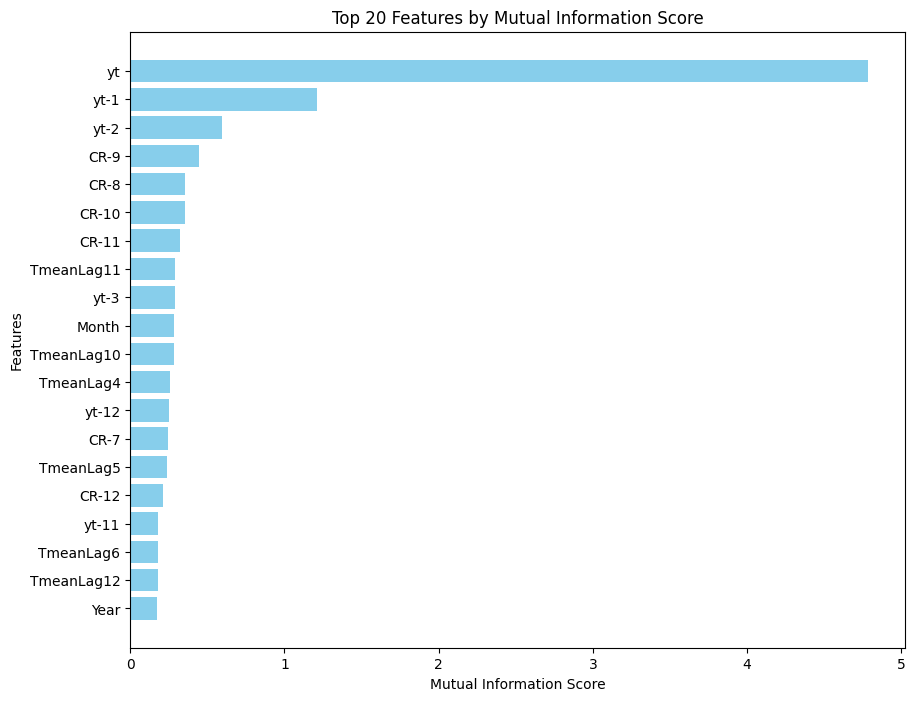

In [7]:
X = df  # Features (including luding the target)
y = df['yt']  # Target variable
# Compute mutual information
mutual_info = mutual_info_regression(X, y)
# Create a DataFrame to display the mutual information scores for each feature
mi_scores_df = pd.DataFrame(mutual_info, index=X.columns, columns=['Mutual Information Score'])
# Sort the DataFrame by mutual information score in descending order
mi_scores_df = mi_scores_df.sort_values(by='Mutual Information Score', ascending=False)

print(mi_scores_df.head(20))
# Get the top 20 features
top_features = mi_scores_df.head(20)

# Plot the horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(top_features.index, top_features['Mutual Information Score'], color='skyblue')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.title('Top 20 Features by Mutual Information Score')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest score at the top
plt.show()

In [8]:
# Creating datase with mutual information score and domain knowledge
print(mi_scores_df.index[:top_x])
dataset_custom = df.loc[:, mi_scores_df.index[:top_x]]
# dataset_custom = df[['yt','yt-1','CR-9','CR-8', 'CR-10', 'CR-11', 'TmeanLag11','Month','yt-3','TmeanLag10', 'yt-12', 'TmeanLag5']]

Index(['yt', 'yt-1', 'yt-2', 'CR-9', 'CR-8', 'CR-10', 'CR-11', 'TmeanLag11',
       'yt-3', 'Month', 'TmeanLag10', 'TmeanLag4', 'yt-12'],
      dtype='object')


In [9]:
def get_combined_data():
  df1=pd.read_csv('Data/SS.01 from 1981-2017.csv')
  df2=pd.read_csv('Data/SS.02 from 1981-2017.csv')
  df7=pd.read_csv('Data/SS.07 from 1981-2017.csv')
  df9=pd.read_csv('Data/SS.09 from 1981-2017.csv')
  df10=pd.read_csv('Data/SS.10 from 1981-2017.csv')
  df101=pd.read_csv('Data/SS.101 from 1981-2017.csv')
  df108=pd.read_csv('Data/SS.108 from 1981-2017.csv')

  # Combine corresponding elements from each dataset excluding "Date" column
  df = (df1.drop(columns=['Date']) + df2.drop(columns=['Date']) + df7.drop(columns=['Date']) +
                  df9.drop(columns=['Date']) + df10.drop(columns=['Date']) + df101.drop(columns=['Date']) +
                  df108.drop(columns=['Date'])) / 7

  # Add "Date" column back to the combined data
  df['Date'] = df1['Date']

  df['Date Time'] = pd.to_datetime(df['Date'], dayfirst=False)
  df['Day'] = df['Date Time'].dt.day
  df['Month'] = df['Date Time'].dt.month
  df['Year'] = df['Date Time'].dt.year
  df.set_index('Date Time', inplace=True)
  df.drop(['Date'], axis=1, inplace=True)
  df.drop(['Day'], axis=1, inplace=True)
  # df.head()

  return df.loc[:, mi_scores_df.index[:top_x]]

In [10]:
# Define window size (number of time steps) & ahead predictions formation
def generate_time_series_data(df, window_size, step):

    # Define lists to store features and target
    X_features = []
    y_target = []

    # Iterate over each row in the DataFrame
    for i in range(df.shape[0] - window_size-step):
        # Extract the features for the current window
        window_features = []
        for j in range(window_size):
            window_features.append(df.iloc[i + j, :].values)
        X_features.append(window_features)

        # Append the target value (12 time steps ahead) to the target list
        y_target.append(df.iloc[i + window_size + step, 0])  # Assuming the target is in the first column

    # Convert lists to numpy arrays
    X = np.array(X_features)
    y_target = np.array(y_target)
    y=np.reshape(y_target, (len(y_target),1))
    # Print the shapes of X and y
    return X, y

### Dataset preperation for 1 month ahead prediction

In [11]:
window_size = 1
step = 0
data_8, target_8 = generate_time_series_data(dataset_custom, window_size,step)

### LSTM model Creation

In [12]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

callbacks = [EarlyStopping(monitor='val_loss', patience=40, mode='min', verbose=1)]

def create_model(batch_size=16, optimizer='SGD', activation='leaky_relu', dropout_rate=0.2, lstm_units=128, dense_units=64, seed_value=42):
    np.random.seed(seed_value)  # Set seed for NumPy
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(window_size, n_features)))

    if activation == 'leaky_relu':
        model.add(LeakyReLU(alpha=0.5))
    else:
        model.add(Activation(activation))

    model.add(LSTM(lstm_units, return_sequences=True))

    if activation == 'leaky_relu':
        model.add(LeakyReLU(alpha=0.2))
    else:
        model.add(Activation(activation))

    model.add(Dropout(dropout_rate))
    model.add(LSTM(int(lstm_units/2), return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units))
    model.add(Dense(1))

    if optimizer == 'SGD':
        optimizer = SGD()
    elif optimizer == 'RMSprop':
        optimizer = RMSprop()
    elif optimizer == 'Adam':
        optimizer = Adam()

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', rmse])

    return model

### MinMax scaling the data

In [13]:
def scale_data(features, target):
    # Reshape the features data to 2D (samples * time steps, features) for scaling
    features_2d = features.reshape(-1, features.shape[-1])
    # Apply MinMaxScaler to features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler.fit_transform(features_2d)
    # Apply MinMaxScaler to target
    scaled_target = scaler.fit_transform(target)
    # Reshape the scaled features data back to 3D (samples, time steps, features)
    scaled_features = scaled_features.reshape(features.shape)
    return scaled_features, scaled_target, scaler


## 1 month ahead

In [14]:
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data_8.reshape(-1, data_8.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target_8)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data_8.shape)
dataset_1, target_1, scaler = scale_data(data_8, target_8)

In [15]:
#dataset_1, target_1 = scale_data(data_6, target_6)
X_train = dataset_1[:-65]
y_train = target_1[:-65]
n_features= X_train.shape[2]
n_features

13

In [16]:
import time
# Create the model using the best parameters
best_model = create_model(batch_size=8, lstm_units=128, dropout_rate=0.15, dense_units=64, optimizer='Adam', activation=LeakyReLU(alpha=0.25))
# Start the timer
start_time = time.time()
# Train the model with the entire training data
history = best_model.fit(X_train, y_train, validation_split=0.15, epochs=200, batch_size=8, callbacks=callbacks)
# End the timer
end_time = time.time()
# Calculate the elapsed time
training_time = end_time - start_time

Epoch 1/200
41/41 [==============================] - 8s 48ms/step - loss: 0.0556 - mae: 0.1830 - rmse: 0.2150 - val_loss: 0.0121 - val_mae: 0.0872 - val_rmse: 0.0924
Epoch 2/200
41/41 [==============================] - 0s 11ms/step - loss: 0.0161 - mae: 0.1013 - rmse: 0.1182 - val_loss: 0.0053 - val_mae: 0.0610 - val_rmse: 0.0741
Epoch 3/200
41/41 [==============================] - 1s 36ms/step - loss: 0.0083 - mae: 0.0711 - rmse: 0.0860 - val_loss: 0.0037 - val_mae: 0.0492 - val_rmse: 0.0624
Epoch 4/200
41/41 [==============================] - 1s 18ms/step - loss: 0.0062 - mae: 0.0618 - rmse: 0.0764 - val_loss: 0.0036 - val_mae: 0.0432 - val_rmse: 0.0619
Epoch 5/200
41/41 [==============================] - 1s 13ms/step - loss: 0.0064 - mae: 0.0605 - rmse: 0.0751 - val_loss: 0.0039 - val_mae: 0.0456 - val_rmse: 0.0641
Epoch 6/200
41/41 [==============================] - 1s 14ms/step - loss: 0.0052 - mae: 0.0554 - rmse: 0.0682 - val_loss: 0.0028 - val_mae: 0.0389 - val_rmse: 0.0523
Epoc

In [17]:
# Save the model
# Save the trained model
best_model.save(avg_1_month_save_path)
print("Model saved successfully.")

Model saved successfully.


#### 7 indidividual dataset preperatuin for test purpose

In [18]:
df1=pd.read_csv('Data/SS.01 from 1981-2017.csv')
df2=pd.read_csv('Data/SS.02 from 1981-2017.csv')
df7=pd.read_csv('Data/SS.07 from 1981-2017.csv')
df9=pd.read_csv('Data/SS.09 from 1981-2017.csv')
df10=pd.read_csv('Data/SS.10 from 1981-2017.csv')
df101=pd.read_csv('Data/SS.101 from 1981-2017.csv')
df108=pd.read_csv('Data/SS.108 from 1981-2017.csv')

In [19]:
def preprocess_dataset(df):
    df['Date Time'] = pd.to_datetime(df['Date'], dayfirst=False)
    df['Day'] = df['Date Time'].dt.day
    df['Month'] = df['Date Time'].dt.month
    df['Year'] = df['Date Time'].dt.year
    df.set_index('Date Time', inplace=True)
    df.drop(['Date'], axis=1, inplace=True)
    df.drop(['Day'], axis=1, inplace=True)
    return df.loc[:, mi_scores_df.index[:top_x]]
    # return df[['yt','yt-1','CR-9','CR-8', 'CR-10', 'CR-11', 'TmeanLag11','Month','yt-3','TmeanLag10', 'yt-12', 'TmeanLag5']]

# Read each dataset and apply the preprocessing function
df1 = preprocess_dataset(df1)
df2 = preprocess_dataset(df2)
df7 = preprocess_dataset(df7)
df9 = preprocess_dataset(df9)
df10 = preprocess_dataset(df10)
df101 = preprocess_dataset(df101)
df108 = preprocess_dataset(df108)


### Calculations for well-001

In [20]:
window_size = 1
step = 0
data, target = generate_time_series_data(df1, window_size,step)
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data.reshape(-1, data.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data.shape)
dataset_1, target_1, scaler = scale_data(data, target)
X_test = dataset_1[-65:]
y_test = target_1[-65:]

In [21]:
# Evaluate the model without predictions
evaluate_model_without_predictions(best_model, X_test, y_test, history)

3/3 [==============================] - 0s 6ms/step - loss: 0.0026 - mae: 0.0418 - rmse: 0.0365
Training time: None seconds
Train Loss: 0.002622105646878481
Train MAE: 0.04175326228141785
Train RMSE: 0.036470551043748856


In [22]:
# Generate predictions
predictions = best_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions': predictions_1d, 'Actuals': y_test_1d})
test_results.tail()

3/3 [==============================] - 2s 8ms/step


,Test Predictions,Actuals
60,6.461779,6.440000
61,6.580832,6.620000
62,6.683242,6.620000
63,6.686253,6.660000
64,6.680657,6.672139


Root Mean Squared Error (RMSE): 0.07
NSE Score: 0.90
R-squared (R2) Score: 0.92
Mean Squared Error (MSE): 0.00
Mean Absolute Error (MAE): 0.06
RSR (RSR): 0.31
KGE_09 Score: 0.84
KGE_12 Score: 0.84


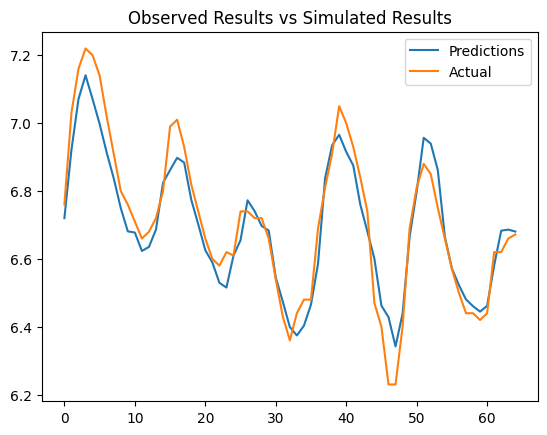

In [23]:
evaluate_predictions(test_results)

In [24]:
# Assuming test_results is your DataFrame
test_results.to_csv('ModelOutputs/avg_model_test_results_S01_1_month.csv', index=False)

### Calculations for well-002


In [25]:
window_size = 1
step = 0
data, target = generate_time_series_data(df2, window_size, step)
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data.reshape(-1, data.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data.shape)
dataset_1, target_1, scaler = scale_data(data, target)
X_test = dataset_1[-65:]
y_test = target_1[-65:]

In [26]:
# Evaluate the model without predictions
evaluate_model_without_predictions(best_model, X_test, y_test, history)

3/3 [==============================] - 0s 6ms/step - loss: 0.0015 - mae: 0.0291 - rmse: 0.0265
Training time: None seconds
Train Loss: 0.0015058990102261305
Train MAE: 0.029125630855560303
Train RMSE: 0.026545271277427673


In [27]:
# Generate predictions
predictions = best_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions': predictions_1d, 'Actuals': y_test_1d})
print(test_results.tail())

3/3 [==============================] - 0s 5ms/step
    Test Predictions  Actuals
60          7.744667  7.69000
61          7.904489  7.96000
62          8.073579  8.02000
63          8.119765  8.09000
64          8.122469  8.12935


Root Mean Squared Error (RMSE): 0.08
NSE Score: 0.93
R-squared (R2) Score: 0.95
Mean Squared Error (MSE): 0.01
Mean Absolute Error (MAE): 0.06
RSR (RSR): 0.26
KGE_09 Score: 0.91
KGE_12 Score: 0.90


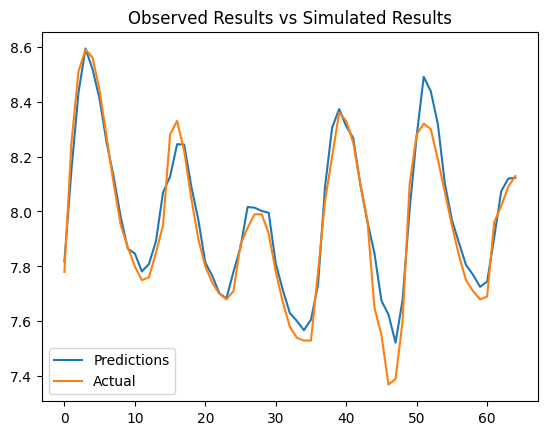

In [28]:
evaluate_predictions(test_results)

In [29]:
# Assuming test_results is your DataFrame
test_results.to_csv('ModelOutputs/avg_model_test_results_S02_1_month.csv', index=False)

### Calculations for well-007

In [32]:
window_size = 1
step = 0
data, target = generate_time_series_data(df7, window_size, step)
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data.reshape(-1, data.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data.shape)
dataset_1, target_1, scaler = scale_data(data, target)
X_test = dataset_1[-65:]
y_test = target_1[-65:]

3/3 [==============================] - 0s 13ms/step - loss: 0.0064 - mae: 0.0704 - rmse: 0.0588
Training time: None seconds
Train Loss: 0.006371492054313421
Train MAE: 0.07042299211025238
Train RMSE: 0.05881962180137634
3/3 [==============================] - 0s 8ms/step
    Test Predictions    Actuals
60         43.664307  43.440000
61         44.197716  44.210000
62         44.818703  44.480000
63         45.002216  44.430000
64         44.597271  44.747006
Root Mean Squared Error (RMSE): 0.76
NSE Score: 0.66
R-squared (R2) Score: 0.76
Mean Squared Error (MSE): 0.58
Mean Absolute Error (MAE): 0.67
RSR (RSR): 0.58
KGE_09 Score: 0.76
KGE_12 Score: 0.76


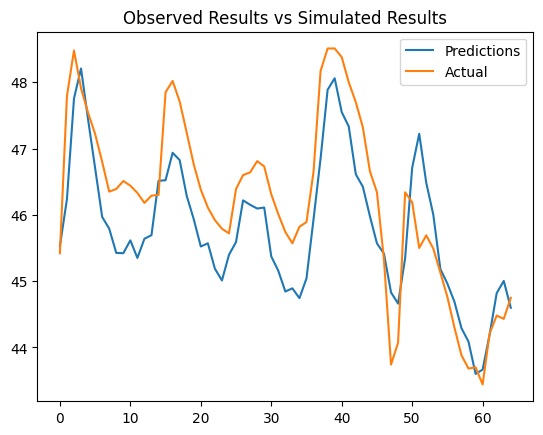

In [33]:
# Evaluate the model without predictions
evaluate_model_without_predictions(best_model, X_test, y_test, history)
# Generate predictions
predictions = best_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions': predictions_1d, 'Actuals': y_test_1d})
print(test_results.tail())
evaluate_predictions(test_results)

In [34]:
# Assuming test_results is your DataFrame
test_results.to_csv('ModelOutputs/avg_model_test_results_S07_1_month.csv', index=False)

### Calculations for well-009

In [37]:
window_size = 1
step = 0
data, target = generate_time_series_data(df9, window_size, step)
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data.reshape(-1, data.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data.shape)
dataset_1, target_1, scaler = scale_data(data, target)
X_test = dataset_1[-65:]
y_test = target_1[-65:]

3/3 [==============================] - 0s 17ms/step - loss: 0.0021 - mae: 0.0315 - rmse: 0.0372
Training time: None seconds
Train Loss: 0.002102613914757967
Train MAE: 0.03148132562637329
Train RMSE: 0.037216249853372574
3/3 [==============================] - 0s 5ms/step
    Test Predictions    Actuals
60          9.340350   9.320000
61          9.770667   9.830000
62         10.105740  10.030000
63         10.199323  10.170000
64         10.154449  10.266475
Root Mean Squared Error (RMSE): 0.21
NSE Score: 0.88
R-squared (R2) Score: 0.92
Mean Squared Error (MSE): 0.04
Mean Absolute Error (MAE): 0.15
RSR (RSR): 0.35
KGE_09 Score: 0.91
KGE_12 Score: 0.90


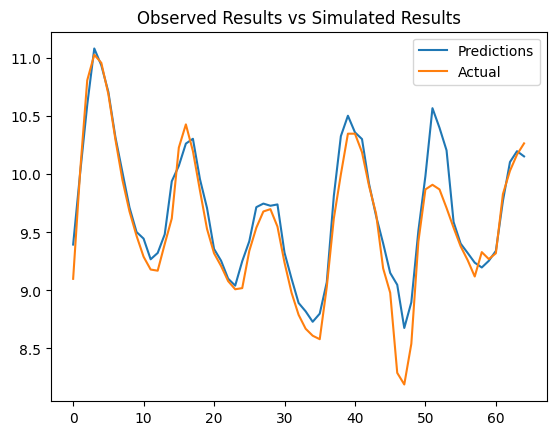

In [38]:
# Evaluate the model without predictions
evaluate_model_without_predictions(best_model, X_test, y_test, history)
# Generate predictions
predictions = best_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions': predictions_1d, 'Actuals': y_test_1d})
print(test_results.tail())
evaluate_predictions(test_results)

In [39]:
# Assuming test_results is your DataFrame
test_results.to_csv('ModelOutputs/avg_model_test_results_S09_1_month.csv', index=False)

### Calculations for well-010

In [40]:
window_size = 1
step = 0
data, target = generate_time_series_data(df10, window_size, step)
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data.reshape(-1, data.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data.shape)
dataset_1, target_1, scaler = scale_data(data, target)
X_test = dataset_1[-65:]
y_test = target_1[-65:]

3/3 [==============================] - 0s 9ms/step - loss: 0.0014 - mae: 0.0307 - rmse: 0.0311
Training time: None seconds
Train Loss: 0.001350156613625586
Train MAE: 0.030719835311174393
Train RMSE: 0.03113923966884613
3/3 [==============================] - 0s 8ms/step
    Test Predictions    Actuals
60         12.831118  12.810000
61         13.318717  13.440000
62         13.794106  13.860000
63         14.113219  14.040000
64         14.083437  14.200659
Root Mean Squared Error (RMSE): 0.22
NSE Score: 0.95
R-squared (R2) Score: 0.97
Mean Squared Error (MSE): 0.05
Mean Absolute Error (MAE): 0.18
RSR (RSR): 0.23
KGE_09 Score: 0.89
KGE_12 Score: 0.88


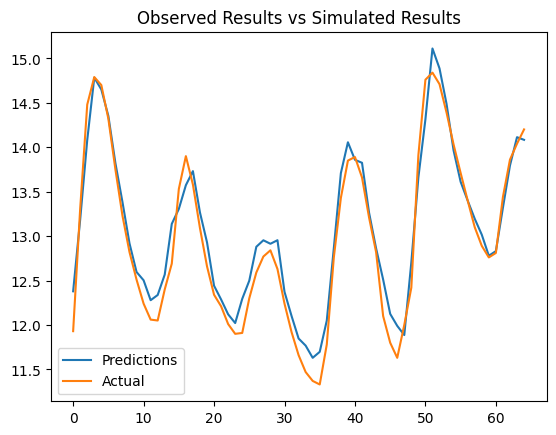

In [41]:
# Evaluate the model without predictions
evaluate_model_without_predictions(best_model, X_test, y_test, history)
# Generate predictions
predictions = best_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions': predictions_1d, 'Actuals': y_test_1d})
print(test_results.tail())
evaluate_predictions(test_results)

In [42]:
# Assuming test_results is your DataFrame
test_results.to_csv('ModelOutputs/avg_model_test_results_S10_1_month.csv', index=False)

### Calculations for well-101

In [43]:
window_size = 1
step = 0
data, target = generate_time_series_data(df101, window_size, step)
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data.reshape(-1, data.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data.shape)
dataset_1, target_1, scaler = scale_data(data, target)
X_test = dataset_1[-65:]
y_test = target_1[-65:]

3/3 [==============================] - 0s 9ms/step - loss: 0.0014 - mae: 0.0318 - rmse: 0.0267
Training time: None seconds
Train Loss: 0.0014442913234233856
Train MAE: 0.031755734235048294
Train RMSE: 0.026740318164229393
3/3 [==============================] - 0s 9ms/step
    Test Predictions  Actuals
60          8.802011     8.74
61          9.043984     9.09
62          9.274185     9.21
63          9.385325     9.29
64          9.362211     9.35
Root Mean Squared Error (RMSE): 0.11
NSE Score: 0.93
R-squared (R2) Score: 0.96
Mean Squared Error (MSE): 0.01
Mean Absolute Error (MAE): 0.09
RSR (RSR): 0.27
KGE_09 Score: 0.93
KGE_12 Score: 0.93


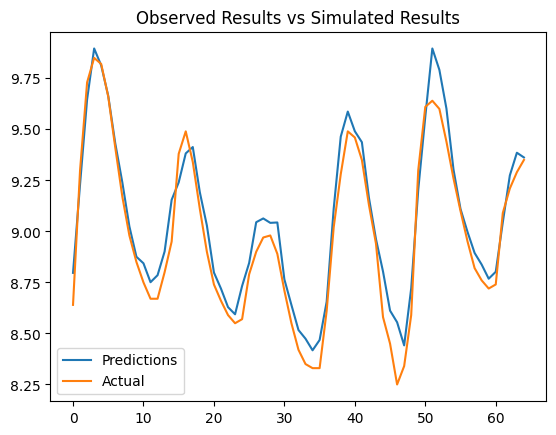

In [44]:
# Evaluate the model without predictions
evaluate_model_without_predictions(best_model, X_test, y_test, history)
# Generate predictions
predictions = best_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions': predictions_1d, 'Actuals': y_test_1d})
print(test_results.tail())
evaluate_predictions(test_results)

In [45]:
# Assuming test_results is your DataFrame
test_results.to_csv('ModelOutputs/avg_model_test_results_S101_1_month.csv', index=False)

### Calculations for well-108

In [46]:
window_size = 1
step = 0
data, target= generate_time_series_data(df108, window_size, step)
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data.reshape(-1, data.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data.shape)
dataset_1, target_1, scaler = scale_data(data, target)
X_test = dataset_1[-65:]
y_test = target_1[-65:]

3/3 [==============================] - 0s 12ms/step - loss: 0.0045 - mae: 0.0575 - rmse: 0.0449
Training time: None seconds
Train Loss: 0.004485438112169504
Train MAE: 0.05746591091156006
Train RMSE: 0.04493364691734314
3/3 [==============================] - 0s 8ms/step
    Test Predictions   Actuals
60          6.201515  6.190000
61          6.313397  6.340000
62          6.403809  6.370000
63          6.422987  6.420000
64          6.413939  6.411271
Root Mean Squared Error (RMSE): 0.10
NSE Score: 0.72
R-squared (R2) Score: 0.81
Mean Squared Error (MSE): 0.01
Mean Absolute Error (MAE): 0.09
RSR (RSR): 0.53
KGE_09 Score: 0.77
KGE_12 Score: 0.77


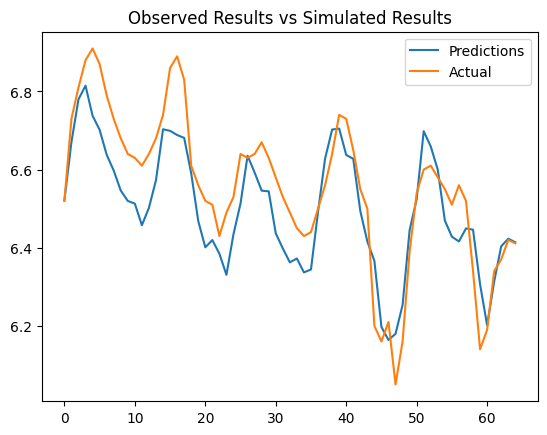

In [47]:
# Evaluate the model without predictions
evaluate_model_without_predictions(best_model, X_test, y_test, history)
# Generate predictions
predictions = best_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions': predictions_1d, 'Actuals': y_test_1d})
print(test_results.tail())
evaluate_predictions(test_results)

In [48]:
# Assuming test_results is your DataFrame
test_results.to_csv('ModelOutputs/avg_model_test_results_S108_1_month.csv', index=False)

In [ ]:
# from keras.models import load_model

# # Define file paths for saving and loading the model
# model_path = 'best_model.h5'

# # Save the trained model
# best_model.save(model_path)
# print("Model saved successfully.")


## 2 months ahead

### Dataset preperation for 2 month ahead prediction

In [49]:
dataset_custom = get_combined_data()
window_size = 1
step = 1
data_8_2, target_8_2 = generate_time_series_data(dataset_custom, window_size, step)


In [50]:
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data_8_2.reshape(-1, data_8_2.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target_8_2)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data_8_2.shape)
dataset_1, target_1, scaler = scale_data(data_8_2, target_8_2)

In [51]:
#dataset_1, target_1 = scale_data(data_8_2, target_8_2)
X_train = dataset_1[:-65]
y_train = target_1[:-65]
n_features= X_train.shape[2]
n_features

13

### 2 month ahead Prediction

In [52]:
# def rmse(y_true, y_pred):
#     return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))
import time
# Create the model using the best parameters
best_model_1 = create_model(batch_size=8, lstm_units=128, dropout_rate=0.15, dense_units=64, optimizer='Adam', activation=LeakyReLU(alpha=0.25))
# Start the timer
start_time = time.time()
# Train the model with the entire training data
history = best_model_1.fit(X_train, y_train, validation_split=0.15, epochs=200, batch_size=8, callbacks=callbacks)
# End the timer
end_time = time.time()
# Calculate the elapsed time
training_time = end_time - start_time

Epoch 1/200
40/40 [==============================] - 9s 54ms/step - loss: 0.0522 - mae: 0.1773 - rmse: 0.2101 - val_loss: 0.0134 - val_mae: 0.0954 - val_rmse: 0.1022
Epoch 2/200
40/40 [==============================] - 0s 8ms/step - loss: 0.0218 - mae: 0.1183 - rmse: 0.1424 - val_loss: 0.0090 - val_mae: 0.0797 - val_rmse: 0.0843
Epoch 3/200
40/40 [==============================] - 0s 8ms/step - loss: 0.0148 - mae: 0.0949 - rmse: 0.1173 - val_loss: 0.0143 - val_mae: 0.1044 - val_rmse: 0.1128
Epoch 4/200
40/40 [==============================] - 0s 9ms/step - loss: 0.0109 - mae: 0.0825 - rmse: 0.1007 - val_loss: 0.0092 - val_mae: 0.0758 - val_rmse: 0.0824
Epoch 5/200
40/40 [==============================] - 0s 8ms/step - loss: 0.0088 - mae: 0.0732 - rmse: 0.0903 - val_loss: 0.0041 - val_mae: 0.0522 - val_rmse: 0.0549
Epoch 6/200
40/40 [==============================] - 0s 8ms/step - loss: 0.0075 - mae: 0.0671 - rmse: 0.0835 - val_loss: 0.0060 - val_mae: 0.0669 - val_rmse: 0.0717
Epoch 7/2

In [53]:
# Save the model
# Save the trained model
best_model_1.save(avg_2_month_save_path)
print("Model saved successfully.")

Model saved successfully.


In [57]:
df1=pd.read_csv('Data/SS.01 from 1981-2017.csv')
df2=pd.read_csv('Data/SS.02 from 1981-2017.csv')
df7=pd.read_csv('Data/SS.07 from 1981-2017.csv')
df9=pd.read_csv('Data/SS.09 from 1981-2017.csv')
df10=pd.read_csv('Data/SS.10 from 1981-2017.csv')
df101=pd.read_csv('Data/SS.101 from 1981-2017.csv')
df108=pd.read_csv('Data/SS.108 from 1981-2017.csv')

In [58]:
def preprocess_dataset(df):
    df['Date Time'] = pd.to_datetime(df['Date'], dayfirst=False)
    df['Day'] = df['Date Time'].dt.day
    df['Month'] = df['Date Time'].dt.month
    df['Year'] = df['Date Time'].dt.year
    df.set_index('Date Time', inplace=True)
    df.drop(['Date'], axis=1, inplace=True)
    df.drop(['Day'], axis=1, inplace=True)
    return df.loc[:, mi_scores_df.index[:top_x]]

# Read each dataset and apply the preprocessing function
df1 = preprocess_dataset(df1)
df2 = preprocess_dataset(df2)
df7 = preprocess_dataset(df7)
df9 = preprocess_dataset(df9)
df10 = preprocess_dataset(df10)
df101 = preprocess_dataset(df101)
df108 = preprocess_dataset(df108)


### Calculations for well-001

In [59]:
window_size = 1
step = 1
data, target = generate_time_series_data(df1, window_size, step)
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data.reshape(-1, data.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data.shape)
dataset_1, target_1, scaler = scale_data(data, target)
X_test = dataset_1[-65:]
y_test = target_1[-65:]

In [60]:
# Evaluate the model without predictions
evaluate_model_without_predictions(best_model_1, X_test, y_test, history)

3/3 [==============================] - 0s 7ms/step - loss: 0.0058 - mae: 0.0642 - rmse: 0.0536
Training time: None seconds
Train Loss: 0.005824835505336523
Train MAE: 0.06415127962827682
Train RMSE: 0.053560178726911545


In [61]:
# Generate predictions
predictions = best_model_1.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions': predictions_1d, 'Actuals': y_test_1d})
test_results.tail()

3/3 [==============================] - 1s 5ms/step


,Test Predictions,Actuals
60,6.450999,6.440000
61,6.542157,6.620000
62,6.608810,6.620000
63,6.697422,6.660000
64,6.683382,6.672139


Root Mean Squared Error (RMSE): 0.10
NSE Score: 0.80
R-squared (R2) Score: 0.85
Mean Squared Error (MSE): 0.01
Mean Absolute Error (MAE): 0.09
RSR (RSR): 0.45
KGE_09 Score: 0.83
KGE_12 Score: 0.83


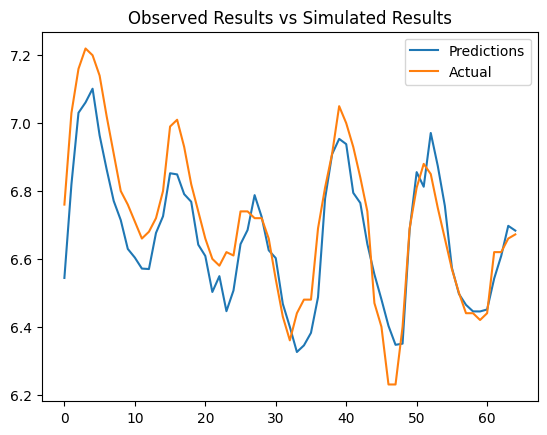

In [62]:
evaluate_predictions(test_results)

In [63]:
# Assuming test_results is your DataFrame
test_results.to_csv('ModelOutputs/avg_model_test_results_S01_2_month.csv', index=False)

### Calculations for well-002


In [64]:
window_size = 1
step = 1
data, target = generate_time_series_data(df2, window_size,step)
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data.reshape(-1, data.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data.shape)
dataset_1, target_1, scaler = scale_data(data, target)
X_test = dataset_1[-65:]
y_test = target_1[-65:]

In [65]:
# Evaluate the model without predictions
evaluate_model_without_predictions(best_model_1, X_test, y_test, history)

3/3 [==============================] - 0s 6ms/step - loss: 0.0019 - mae: 0.0322 - rmse: 0.0297
Training time: None seconds
Train Loss: 0.00190963433124125
Train MAE: 0.03217988461256027
Train RMSE: 0.029722997918725014


In [66]:
# Generate predictions
predictions = best_model_1.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions': predictions_1d, 'Actuals': y_test_1d})
print(test_results.tail())

3/3 [==============================] - 0s 4ms/step
    Test Predictions  Actuals
60          7.708633  7.69000
61          7.857099  7.96000
62          7.946538  8.02000
63          8.106424  8.09000
64          8.127160  8.12935


Root Mean Squared Error (RMSE): 0.09
NSE Score: 0.91
R-squared (R2) Score: 0.91
Mean Squared Error (MSE): 0.01
Mean Absolute Error (MAE): 0.06
RSR (RSR): 0.30
KGE_09 Score: 0.91
KGE_12 Score: 0.91


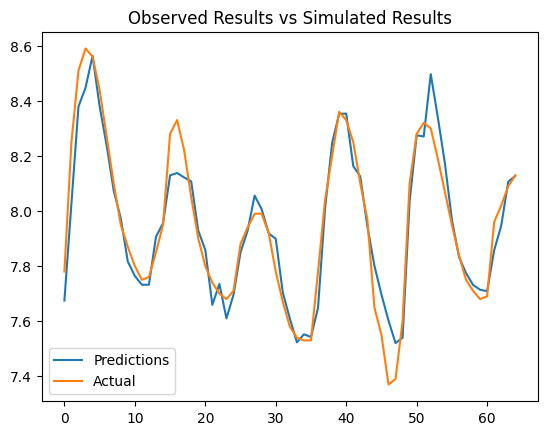

In [67]:
evaluate_predictions(test_results)

In [68]:
# Assuming test_results is your DataFrame
test_results.to_csv('ModelOutputs/avg_model_test_results_S02_2_month.csv', index=False)

### Calculations for well-007

In [69]:
window_size = 1
step = 1
data, target = generate_time_series_data(df7, window_size,step)
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data.reshape(-1, data.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data.shape)
dataset_1, target_1, scaler = scale_data(data, target)
X_test = dataset_1[-65:]
y_test = target_1[-65:]

3/3 [==============================] - 0s 7ms/step - loss: 0.0202 - mae: 0.1246 - rmse: 0.1018
Training time: None seconds
Train Loss: 0.020230701193213463
Train MAE: 0.1246158629655838
Train RMSE: 0.10178998857736588
3/3 [==============================] - 0s 5ms/step
    Test Predictions    Actuals
60         43.417976  43.440000
61         43.976280  44.210000
62         44.390232  44.480000
63         45.053642  44.430000
64         44.939060  44.747006
Root Mean Squared Error (RMSE): 1.36
NSE Score: -0.08
R-squared (R2) Score: 0.53
Mean Squared Error (MSE): 1.85
Mean Absolute Error (MAE): 1.19
RSR (RSR): 1.04
KGE_09 Score: 0.66
KGE_12 Score: 0.67


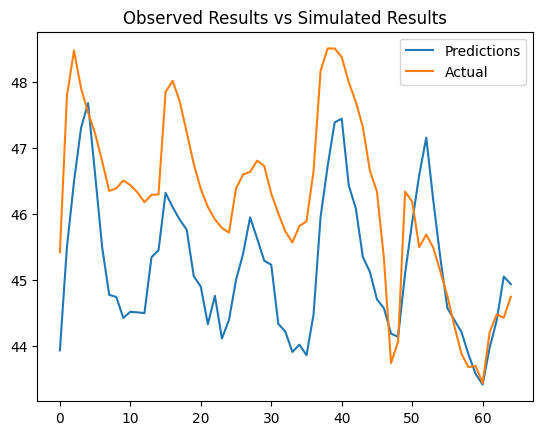

In [70]:
# Evaluate the model without predictions
evaluate_model_without_predictions(best_model_1, X_test, y_test, history)
# Generate predictions
predictions = best_model_1.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions': predictions_1d, 'Actuals': y_test_1d})
print(test_results.tail())
evaluate_predictions(test_results)

In [71]:
# Assuming test_results is your DataFrame
test_results.to_csv('ModelOutputs/avg_model_test_results_S07_2_month.csv', index=False)

### Calculations for well-009

In [72]:
window_size = 1
step = 1
data, target= generate_time_series_data(df9, window_size,step)
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data.reshape(-1, data.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data.shape)
dataset_1, target_1, scaler = scale_data(data, target)
X_test = dataset_1[-65:]
y_test = target_1[-65:]

3/3 [==============================] - 0s 12ms/step - loss: 0.0022 - mae: 0.0325 - rmse: 0.0378
Training time: None seconds
Train Loss: 0.0022098131012171507
Train MAE: 0.03249042108654976
Train RMSE: 0.03775567188858986
3/3 [==============================] - 0s 7ms/step
    Test Predictions    Actuals
60          9.235726   9.320000
61          9.649878   9.830000
62          9.851713  10.030000
63         10.150231  10.170000
64         10.160969  10.266475
Root Mean Squared Error (RMSE): 0.22
NSE Score: 0.87
R-squared (R2) Score: 0.88
Mean Squared Error (MSE): 0.05
Mean Absolute Error (MAE): 0.15
RSR (RSR): 0.36
KGE_09 Score: 0.92
KGE_12 Score: 0.92


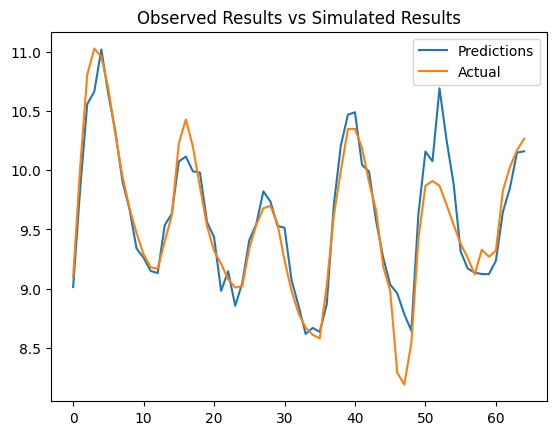

In [73]:
# Evaluate the model without predictions
evaluate_model_without_predictions(best_model_1, X_test, y_test, history)
# Generate predictions
predictions = best_model_1.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions': predictions_1d, 'Actuals': y_test_1d})
print(test_results.tail())
evaluate_predictions(test_results)

In [74]:
# Assuming test_results is your DataFrame
test_results.to_csv('ModelOutputs/avg_model_test_results_S09_2_month.csv', index=False)

### Calculations for well-010

In [75]:
window_size = 1
step = 1
data, target= generate_time_series_data(df10, window_size, step)
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data.reshape(-1, data.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data.shape)
dataset_1, target_1, scaler = scale_data(data, target)
X_test = dataset_1[-65:]
y_test = target_1[-65:]

3/3 [==============================] - 0s 11ms/step - loss: 0.0017 - mae: 0.0332 - rmse: 0.0354
Training time: None seconds
Train Loss: 0.0017418592469766736
Train MAE: 0.03322019428014755
Train RMSE: 0.035410791635513306
3/3 [==============================] - 0s 9ms/step
    Test Predictions    Actuals
60         12.659376  12.810000
61         13.106795  13.440000
62         13.424726  13.860000
63         13.882544  14.040000
64         14.066733  14.200659
Root Mean Squared Error (RMSE): 0.25
NSE Score: 0.93
R-squared (R2) Score: 0.94
Mean Squared Error (MSE): 0.06
Mean Absolute Error (MAE): 0.20
RSR (RSR): 0.26
KGE_09 Score: 0.88
KGE_12 Score: 0.88


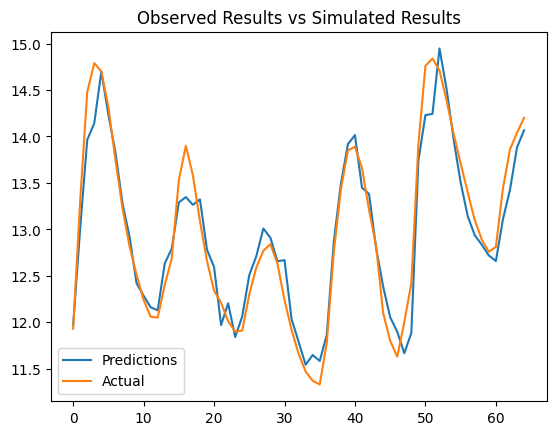

In [76]:
# Evaluate the model without predictions
evaluate_model_without_predictions(best_model_1, X_test, y_test, history)
# Generate predictions
predictions = best_model_1.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions': predictions_1d, 'Actuals': y_test_1d})
print(test_results.tail())
evaluate_predictions(test_results)

In [77]:
# Assuming test_results is your DataFrame
test_results.to_csv('ModelOutputs/avg_model_test_results_S10_2_month.csv', index=False)

### Calculations for well-101

In [78]:
window_size = 1
step = 1
data, target= generate_time_series_data(df101, window_size, step)
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data.reshape(-1, data.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data.shape)
dataset_1, target_1, scaler = scale_data(data, target)
X_test = dataset_1[-65:]
y_test = target_1[-65:]

3/3 [==============================] - 0s 10ms/step - loss: 0.0013 - mae: 0.0286 - rmse: 0.0280
Training time: None seconds
Train Loss: 0.001297711511142552
Train MAE: 0.02858840860426426
Train RMSE: 0.028047660365700722
3/3 [==============================] - 0s 14ms/step
    Test Predictions  Actuals
60          8.724731     8.74
61          8.960469     9.09
62          9.095755     9.21
63          9.331284     9.29
64          9.383617     9.35
Root Mean Squared Error (RMSE): 0.10
NSE Score: 0.94
R-squared (R2) Score: 0.94
Mean Squared Error (MSE): 0.01
Mean Absolute Error (MAE): 0.08
RSR (RSR): 0.25
KGE_09 Score: 0.95
KGE_12 Score: 0.95


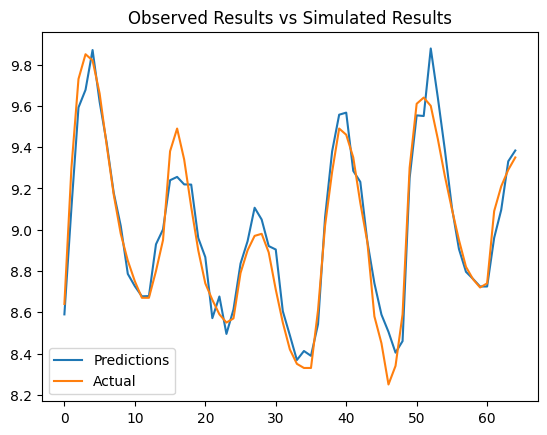

In [79]:
# Evaluate the model without predictions
evaluate_model_without_predictions(best_model_1, X_test, y_test, history)
# Generate predictions
predictions = best_model_1.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions': predictions_1d, 'Actuals': y_test_1d})
print(test_results.tail())
evaluate_predictions(test_results)

In [80]:
# Assuming test_results is your DataFrame
test_results.to_csv('ModelOutputs/avg_model_test_results_S101_2_month.csv', index=False)

### Calculations for well-108

In [81]:
window_size = 1
step = 1
data, target = generate_time_series_data(df108, window_size, step)
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data.reshape(-1, data.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data.shape)
dataset_1, target_1, scaler = scale_data(data, target)
X_test = dataset_1[-65:]
y_test = target_1[-65:]

3/3 [==============================] - 0s 12ms/step - loss: 0.0103 - mae: 0.0872 - rmse: 0.0709
Training time: None seconds
Train Loss: 0.010293110273778439
Train MAE: 0.08723476529121399
Train RMSE: 0.07092205435037613
3/3 [==============================] - 0s 11ms/step
    Test Predictions   Actuals
60          6.281103  6.190000
61          6.248131  6.340000
62          6.327816  6.370000
63          6.426546  6.420000
64          6.429370  6.411271
Root Mean Squared Error (RMSE): 0.15
NSE Score: 0.36
R-squared (R2) Score: 0.63
Mean Squared Error (MSE): 0.02
Mean Absolute Error (MAE): 0.13
RSR (RSR): 0.80
KGE_09 Score: 0.76
KGE_12 Score: 0.77


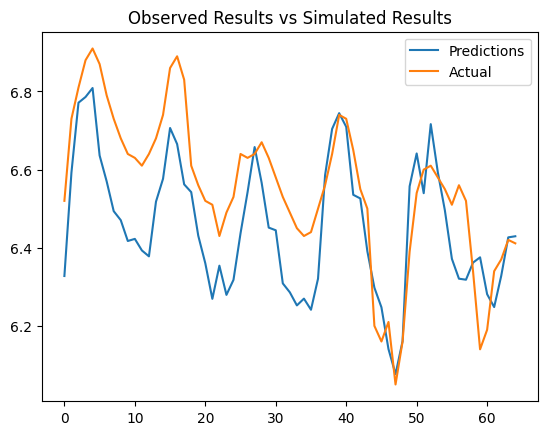

In [82]:
# Evaluate the model without predictions
evaluate_model_without_predictions(best_model_1, X_test, y_test, history)
# Generate predictions
predictions = best_model_1.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions': predictions_1d, 'Actuals': y_test_1d})
print(test_results.tail())
evaluate_predictions(test_results)

In [83]:
# Assuming test_results is your DataFrame
test_results.to_csv('ModelOutputs/avg_model_test_results_S108_2_month.csv', index=False)

In [ ]:
# from keras.models import load_model

# # Define file paths for saving and loading the model
# model_path = 'best_model_1.h5'

# # Save the trained model
# best_model_1.save(model_path)
# print("Model saved successfully.")

Model saved successfully.


### Dataset preperation for 3 month ahead prediction

In [84]:
dataset_custom = get_combined_data()
window_size = 1
step = 2
data_8_3, target_8_3 = generate_time_series_data(dataset_custom, window_size, step)


In [ ]:
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data_8_3.reshape(-1, data_8_3.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target_8_3)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data_8_3.shape)

In [85]:
#dataset_1, target_1 = scale_data(data_8_2, target_8_2)
dataset_1, target_1, scaler = scale_data(data_8_3, target_8_3)
X_train = dataset_1[:-65]
y_train = target_1[:-65]
n_features= X_train.shape[2]
n_features

13

### 3 month ahead Prediction

In [86]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))
import time
# Create the model using the best parameters
best_model_2 = create_model(batch_size=8, lstm_units=128, dropout_rate=0.15, dense_units=64, optimizer='Adam', activation=LeakyReLU(alpha=0.25))
# Start the timer
start_time = time.time()
# Train the model with the entire training data
history = best_model_2.fit(X_train, y_train, validation_split=0.15, epochs=200, batch_size=8, callbacks=callbacks)
# End the timer
end_time = time.time()
# Calculate the elapsed time
training_time = end_time - start_time

Epoch 1/200
40/40 [==============================] - 10s 50ms/step - loss: 0.0533 - mae: 0.1786 - rmse: 0.2106 - val_loss: 0.0144 - val_mae: 0.0999 - val_rmse: 0.1079
Epoch 2/200
40/40 [==============================] - 0s 9ms/step - loss: 0.0276 - mae: 0.1305 - rmse: 0.1587 - val_loss: 0.0129 - val_mae: 0.0893 - val_rmse: 0.0984
Epoch 3/200
40/40 [==============================] - 0s 9ms/step - loss: 0.0213 - mae: 0.1164 - rmse: 0.1414 - val_loss: 0.0089 - val_mae: 0.0812 - val_rmse: 0.0919
Epoch 4/200
40/40 [==============================] - 0s 9ms/step - loss: 0.0187 - mae: 0.1063 - rmse: 0.1300 - val_loss: 0.0053 - val_mae: 0.0575 - val_rmse: 0.0713
Epoch 5/200
40/40 [==============================] - 0s 9ms/step - loss: 0.0143 - mae: 0.0918 - rmse: 0.1126 - val_loss: 0.0048 - val_mae: 0.0515 - val_rmse: 0.0637
Epoch 6/200
40/40 [==============================] - 0s 10ms/step - loss: 0.0122 - mae: 0.0851 - rmse: 0.1037 - val_loss: 0.0059 - val_mae: 0.0600 - val_rmse: 0.0713
Epoch 7

In [87]:
# Save the model
# Save the trained model
best_model_2.save(avg_3_month_save_path)
print("Model saved successfully.")

Model saved successfully.


In [90]:
df1=pd.read_csv('Data/SS.01 from 1981-2017.csv')
df2=pd.read_csv('Data/SS.02 from 1981-2017.csv')
df7=pd.read_csv('Data/SS.07 from 1981-2017.csv')
df9=pd.read_csv('Data/SS.09 from 1981-2017.csv')
df10=pd.read_csv('Data/SS.10 from 1981-2017.csv')
df101=pd.read_csv('Data/SS.101 from 1981-2017.csv')
df108=pd.read_csv('Data/SS.108 from 1981-2017.csv')

In [91]:
def preprocess_dataset(df):
    df['Date Time'] = pd.to_datetime(df['Date'], dayfirst=False)
    df['Day'] = df['Date Time'].dt.day
    df['Month'] = df['Date Time'].dt.month
    df['Year'] = df['Date Time'].dt.year
    df.set_index('Date Time', inplace=True)
    df.drop(['Date'], axis=1, inplace=True)
    df.drop(['Day'], axis=1, inplace=True)
    return df.loc[:, mi_scores_df.index[:top_x]]

# Read each dataset and apply the preprocessing function
df1 = preprocess_dataset(df1)
df2 = preprocess_dataset(df2)
df7 = preprocess_dataset(df7)
df9 = preprocess_dataset(df9)
df10 = preprocess_dataset(df10)
df101 = preprocess_dataset(df101)
df108 = preprocess_dataset(df108)


### Calculations for well-001

In [92]:
window_size = 1
step = 2
data, target = generate_time_series_data(df1, window_size, step)
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data.reshape(-1, data.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data.shape)
dataset_1, target_1, scaler = scale_data(data, target)
X_test = dataset_1[-65:]
y_test = target_1[-65:]

In [93]:
# Evaluate the model without predictions
evaluate_model_without_predictions(best_model_2, X_test, y_test, history)

3/3 [==============================] - 0s 9ms/step - loss: 0.0095 - mae: 0.0780 - rmse: 0.0676
Training time: None seconds
Train Loss: 0.009478566236793995
Train MAE: 0.07797645032405853
Train RMSE: 0.06761287897825241


In [94]:
# Generate predictions
predictions = best_model_2.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions': predictions_1d, 'Actuals': y_test_1d})
test_results.tail()

3/3 [==============================] - 1s 5ms/step


,Test Predictions,Actuals
60,6.501562,6.440000
61,6.609849,6.620000
62,6.661802,6.620000
63,6.631044,6.660000
64,6.659238,6.672139


Root Mean Squared Error (RMSE): 0.13
NSE Score: 0.67
R-squared (R2) Score: 0.79
Mean Squared Error (MSE): 0.02
Mean Absolute Error (MAE): 0.10
RSR (RSR): 0.58
KGE_09 Score: 0.70
KGE_12 Score: 0.71


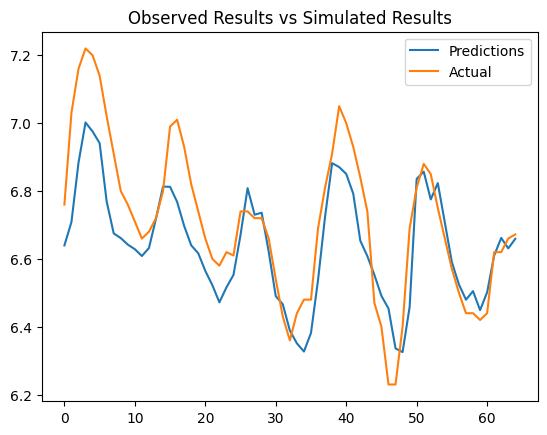

In [95]:
evaluate_predictions(test_results)

In [96]:
# Assuming test_results is your DataFrame
test_results.to_csv('ModelOutputs/avg_model_test_results_S01_3_month.csv', index=False)

### Calculations for well-002


In [97]:
window_size = 1
step = 2
data, target = generate_time_series_data(df2, window_size, step)
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data.reshape(-1, data.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data.shape)
dataset_1, target_1, scaler = scale_data(data, target)
X_test = dataset_1[-65:]
y_test = target_1[-65:]

In [98]:
# Evaluate the model without predictions
evaluate_model_without_predictions(best_model_2, X_test, y_test, history)

3/3 [==============================] - 0s 8ms/step - loss: 0.0052 - mae: 0.0505 - rmse: 0.0614
Training time: None seconds
Train Loss: 0.005155366845428944
Train MAE: 0.05045925825834274
Train RMSE: 0.061355382204055786


In [99]:
# Generate predictions
predictions = best_model_2.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions': predictions_1d, 'Actuals': y_test_1d})
print(test_results.tail())

3/3 [==============================] - 0s 17ms/step
    Test Predictions  Actuals
60          7.735395  7.69000
61          7.894289  7.96000
62          8.001725  8.02000
63          7.960169  8.09000
64          8.050064  8.12935


Root Mean Squared Error (RMSE): 0.14
NSE Score: 0.76
R-squared (R2) Score: 0.82
Mean Squared Error (MSE): 0.02
Mean Absolute Error (MAE): 0.10
RSR (RSR): 0.49
KGE_09 Score: 0.71
KGE_12 Score: 0.72


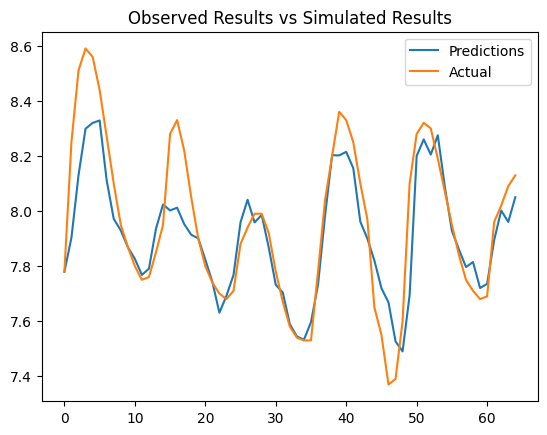

In [100]:
evaluate_predictions(test_results)

In [101]:
# Assuming test_results is your DataFrame
test_results.to_csv('ModelOutputs/avg_model_test_results_S02_3_month.csv', index=False)

### Calculations for well-007

In [102]:
window_size = 1
step = 2
data, target = generate_time_series_data(df7, window_size, step)
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data.reshape(-1, data.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data.shape)
dataset_1, target_1, scaler = scale_data(data, target)
X_test = dataset_1[-65:]
y_test = target_1[-65:]

3/3 [==============================] - 0s 6ms/step - loss: 0.0315 - mae: 0.1537 - rmse: 0.1320
Training time: None seconds
Train Loss: 0.03152896836400032
Train MAE: 0.15373468399047852
Train RMSE: 0.13200734555721283
3/3 [==============================] - 0s 5ms/step
    Test Predictions    Actuals
60         43.702560  43.440000
61         44.341755  44.210000
62         45.008472  44.480000
63         44.784569  44.430000
64         45.125031  44.747006
Root Mean Squared Error (RMSE): 1.70
NSE Score: -0.69
R-squared (R2) Score: 0.37
Mean Squared Error (MSE): 2.88
Mean Absolute Error (MAE): 1.47
RSR (RSR): 1.30
KGE_09 Score: 0.49
KGE_12 Score: 0.51


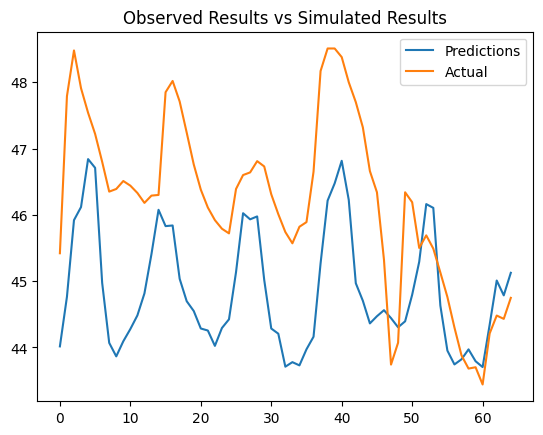

In [103]:
# Evaluate the model without predictions
evaluate_model_without_predictions(best_model_2, X_test, y_test, history)
# Generate predictions
predictions = best_model_2.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions': predictions_1d, 'Actuals': y_test_1d})
print(test_results.tail())
evaluate_predictions(test_results)

In [104]:
# Assuming test_results is your DataFrame
test_results.to_csv('ModelOutputs/avg_model_test_results_S07_3_month.csv', index=False)

### Calculations for well-009

In [105]:
window_size = 1
step = 2
data, target = generate_time_series_data(df9, window_size, step)
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data.reshape(-1, data.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data.shape)
dataset_1, target_1, scaler = scale_data(data, target)
X_test = dataset_1[-65:]
y_test = target_1[-65:]

3/3 [==============================] - 0s 7ms/step - loss: 0.0042 - mae: 0.0472 - rmse: 0.0633
Training time: None seconds
Train Loss: 0.004230368882417679
Train MAE: 0.04723577946424484
Train RMSE: 0.06328801810741425
3/3 [==============================] - 0s 5ms/step
    Test Predictions    Actuals
60          9.426370   9.320000
61          9.799253   9.830000
62          9.904294  10.030000
63          9.782245  10.170000
64          9.986352  10.266475
Root Mean Squared Error (RMSE): 0.30
NSE Score: 0.76
R-squared (R2) Score: 0.80
Mean Squared Error (MSE): 0.09
Mean Absolute Error (MAE): 0.22
RSR (RSR): 0.49
KGE_09 Score: 0.71
KGE_12 Score: 0.72


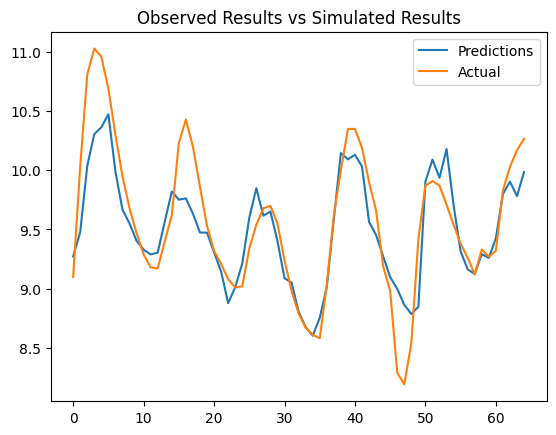

In [106]:
# Evaluate the model without predictions
evaluate_model_without_predictions(best_model_2, X_test, y_test, history)
# Generate predictions
predictions = best_model_2.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions': predictions_1d, 'Actuals': y_test_1d})
print(test_results.tail())
evaluate_predictions(test_results)

In [107]:
# Assuming test_results is your DataFrame
test_results.to_csv('ModelOutputs/avg_model_test_results_S09_3_month.csv', index=False)

### Calculations for well-010

In [108]:
window_size = 1
step = 2
data, target = generate_time_series_data(df10, window_size, step)
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data.reshape(-1, data.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data.shape)
dataset_1, target_1, scaler = scale_data(data, target)
X_test = dataset_1[-65:]
y_test = target_1[-65:]

3/3 [==============================] - 0s 8ms/step - loss: 0.0067 - mae: 0.0632 - rmse: 0.0783
Training time: None seconds
Train Loss: 0.0066766515374183655
Train MAE: 0.06320517510175705
Train RMSE: 0.07830425351858139
3/3 [==============================] - 0s 5ms/step
    Test Predictions    Actuals
60         12.732658  12.810000
61         13.167217  13.440000
62         13.531588  13.860000
63         13.480095  14.040000
64         13.773467  14.200659
Root Mean Squared Error (RMSE): 0.49
NSE Score: 0.74
R-squared (R2) Score: 0.82
Mean Squared Error (MSE): 0.24
Mean Absolute Error (MAE): 0.38
RSR (RSR): 0.51
KGE_09 Score: 0.68
KGE_12 Score: 0.68


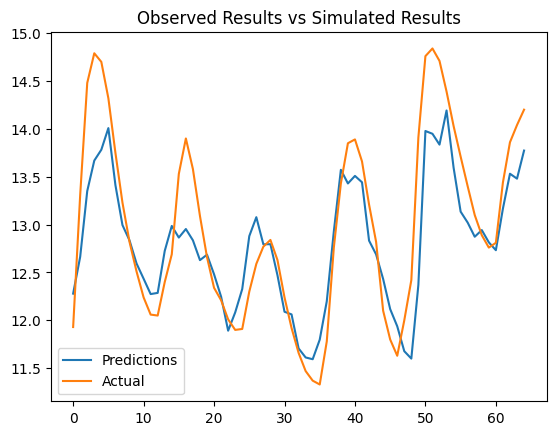

In [109]:
# Evaluate the model without predictions
evaluate_model_without_predictions(best_model_2, X_test, y_test, history)
# Generate predictions
predictions = best_model_2.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions': predictions_1d, 'Actuals': y_test_1d})
print(test_results.tail())
evaluate_predictions(test_results)

In [110]:
# Assuming test_results is your DataFrame
test_results.to_csv('ModelOutputs/avg_model_test_results_S10_3_month.csv', index=False)

### Calculations for well-101

In [111]:
window_size = 1
step = 2
data, target = generate_time_series_data(df101, window_size, step)
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data.reshape(-1, data.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data.shape)
dataset_1, target_1, scaler = scale_data(data, target)
X_test = dataset_1[-65:]
y_test = target_1[-65:]

3/3 [==============================] - 0s 10ms/step - loss: 0.0040 - mae: 0.0467 - rmse: 0.0545
Training time: None seconds
Train Loss: 0.0040096561424434185
Train MAE: 0.04673026129603386
Train RMSE: 0.054491858929395676
3/3 [==============================] - 0s 6ms/step
    Test Predictions  Actuals
60          8.742034     8.74
61          8.979687     9.09
62          9.157688     9.21
63          9.096539     9.29
64          9.242694     9.35
Root Mean Squared Error (RMSE): 0.18
NSE Score: 0.80
R-squared (R2) Score: 0.84
Mean Squared Error (MSE): 0.03
Mean Absolute Error (MAE): 0.14
RSR (RSR): 0.45
KGE_09 Score: 0.74
KGE_12 Score: 0.75


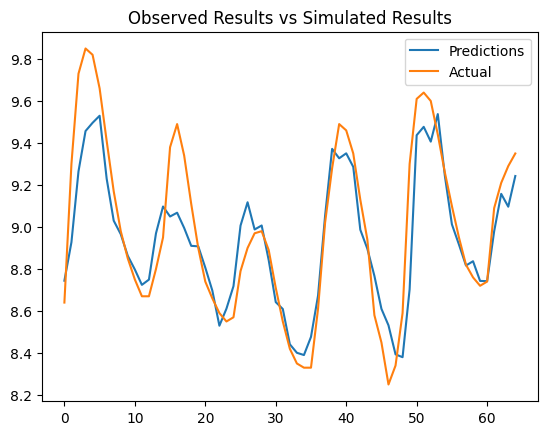

In [112]:
# Evaluate the model without predictions
evaluate_model_without_predictions(best_model_2, X_test, y_test, history)
# Generate predictions
predictions = best_model_2.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions': predictions_1d, 'Actuals': y_test_1d})
print(test_results.tail())
evaluate_predictions(test_results)

In [113]:
# Assuming test_results is your DataFrame
test_results.to_csv('ModelOutputs/avg_model_test_results_S101_3_month.csv', index=False)

### Calculations for well-108

In [116]:
window_size = 1
step = 2
data, target = generate_time_series_data(df108, window_size, step)
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data.reshape(-1, data.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data.shape)
dataset_1, target_1, scaler = scale_data(data, target)
X_test = dataset_1[-65:]
y_test = target_1[-65:]

3/3 [==============================] - 0s 6ms/step - loss: 0.0149 - mae: 0.1058 - rmse: 0.0889
Training time: None seconds
Train Loss: 0.014940409921109676
Train MAE: 0.10576387494802475
Train RMSE: 0.08893907070159912
3/3 [==============================] - 0s 5ms/step
    Test Predictions   Actuals
60          6.460789  6.190000
61          6.423376  6.340000
62          6.293872  6.370000
63          6.324747  6.420000
64          6.375473  6.411271
Root Mean Squared Error (RMSE): 0.18
NSE Score: 0.08
R-squared (R2) Score: 0.51
Mean Squared Error (MSE): 0.03
Mean Absolute Error (MAE): 0.16
RSR (RSR): 0.96
KGE_09 Score: 0.67
KGE_12 Score: 0.67


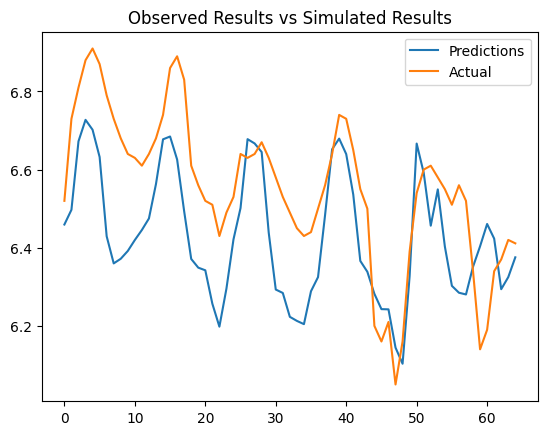

In [117]:
# Evaluate the model without predictions
evaluate_model_without_predictions(best_model_2, X_test, y_test, history)
# Generate predictions
predictions = best_model_2.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions': predictions_1d, 'Actuals': y_test_1d})
print(test_results.tail())
evaluate_predictions(test_results)

In [118]:
# Assuming test_results is your DataFrame
test_results.to_csv('ModelOutputs/avg_model_test_results_S108_3_month.csv', index=False)

In [ ]:
# # Define file paths for saving and loading the model
# model_path = 'best_model_2.h5'

# # Save the trained model
# best_model_2.save(model_path)
# print("Model saved successfully.")

Model saved successfully.
